#  Speech Acoustic Emotion Recognition

## Feature Extraction

In [1]:
# Basic imports
import os
import sys
import glob
import pickle
import warnings
import re
from dotenv import load_dotenv

# Data manipulation and numerical processing libraries
import numpy as np
import pandas as pd

# Audio processing libraries
import librosa
import librosa.display
import soundfile as sf
import opensmile

# Visualization library
import matplotlib.pyplot as plt

# Machine learning and evaluation tools
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

# Progress bar for loops
from tqdm.notebook import tqdm

# Ignore warnings for cleaner output
warnings.filterwarnings("ignore")

# Custom feature extraction modules from psychai (assuming psychai is installed in your environment)
import psychai.feature.feature_extraction.feature_retriever
import psychai.feature.feature_extraction.feature_processor
import psychai.speech_acoustics.feature_extraction.feature_extraction

# Initialize feature processor from psychai
feature_processor = psychai.feature.feature_extraction.feature_processor.FeatureProcessor()

# Set base directories and file paths

load_dotenv(override=True)
huggingface_cache_location = os.getenv("huggingface_cache_location")
datasets_cache_location = os.getenv("datasets_cache_location")
resutls_location = os.getenv("results_location")
resource_path= os.getenv("resources_location")

raw_data_path =  os.path.join(resource_path, "examples", "paper5_mmer_moral","resources","raw_data")
csv_cache_file_path =  os.path.join(resutls_location, "examples", "paper5_mmer_moral", "audio","audio_features_cache_20241216.csv")
csv_results_file_path =  os.path.join(resutls_location, "examples", "paper5_mmer_moral", "audio","audio_features_merged_20241216.csv")
pickle_file_path =  os.path.join(resutls_location, "examples", "paper5_mmer_moral", "audio","audio_features_cache_241204.pkl")
pickle_folder_path =  os.path.join(resutls_location, "examples", "paper5_mmer_moral", "audio")

# Extend system path to current directory (for importing modules if needed)
current_dir = os.path.abspath('../')
sys.path.append(current_dir)

# Import any custom utilities from the parent directory if needed
import local_utilities

# Specify modality (e.g., audio segment type) for processing
modality_value = "Segment_Audio"


#### Rename

If the raw data is not in the correct format, follow these steps to reformat it. If your data format is correct, you can skip this section.

In [6]:
# for user_id in range(5,15):

#     # Format the user folder ID as a three-digit string (e.g., 001, 002, etc.)
#     user_folder = f"{user_id:03d}"

#     # Construct the full path to the modality folder inside the user's directory
#     modality_folder = os.path.join(base_directory, user_folder, modality_value)

#     if os.path.exists(modality_folder):
#         for file_path in os.listdir(modality_folder):
#             old_file_path = os.path.join(modality_folder, file_path)
#             # Regular expression to match the original file format
#             match = re.match(r'PS-9_(\d{3})_(\d{2})_(\d{4})-(\d{2})-(\d{2})_(\d{6})_(\d+)\.(.+)', file_path)
#             match_short = re.match(r'PS-9_(\d{3})_(\d{1})_(\d{4})-(\d{2})-(\d{2})_(\d{6})_(\d+)\.(.+)', file_path)
#             if match_short:
#                 match = match_short
#             if match:
#                 user_number = match.group(1)
#                 step = match.group(2)
#                 year = match.group(3)
#                 month = match.group(4)
#                 day = match.group(5)
#                 time = match.group(6)  # HHMMSS format
#                 sequence = match.group(7)
#                 extension = match.group(8)

#                 # Convert time from HHMMSS to individual components
#                 hour = time[:2]
#                 minute = time[2:4]
#                 second = time[4:]

#                 # Create new file name in the required format
#                 new_file_name = f"PS-9_{user_number}_{step}_{month}_{day}_{hour}_{minute}_{second}_{sequence}.{extension}"
#                 new_file_path = os.path.join(modality_folder, new_file_name)

#                 try:
#                     # Rename the file
#                     os.rename(old_file_path, new_file_path)
#                     print(f"Renamed: {old_file_path} -> {new_file_name}")
#                 except Exception as e:
#                     print(f"Error renaming file {file_path}: {e}")
#             else:
#                 print(f"Filename format does not match: {file_path}")
    

### Prepare data

In [7]:
single_analysis = local_utilities.SingleModalityAnalysis()

filters = [(2, '25'), (2, '26'), (2, '27'), (2, '28')]

# consider user from 005~013
user_ids = range(11, 14)

# rct.csv contains user group information
#merging_pdf = pd.read_csv('./resources/data/rct/rct.csv')

group_info_path =  os.path.join(resource_path, "examples", "paper5_mmer_moral", "group_info","rct.csv")
merging_pdf = pd.read_csv(group_info_path)

df_largest = single_analysis.prosss_folder(raw_data_path , filters, user_ids, merging_pdf, modality_value)

Segment_Audio folder not found for user 012
Total matching files found: 17
   user_id       modality  attribute_index attribute_value  \
0       11  Segment_Audio                2              25   
1       11  Segment_Audio                2              26   
2       11  Segment_Audio                2              27   
3       11  Segment_Audio                2              28   
4       13  Segment_Audio                2              25   
5       13  Segment_Audio                2              26   
6       13  Segment_Audio                2              27   
7       13  Segment_Audio                2              28   

                                               files  file_size part_0 part_1  \
0  /mnt/c/Working/Programming/Python/resources/ws...   11522126   PS-9    011   
1  /mnt/c/Working/Programming/Python/resources/ws...    8446030   PS-9    011   
2  /mnt/c/Working/Programming/Python/resources/ws...    9023566   PS-9    011   
3  /mnt/c/Working/Programming/Python/resou

### Single File Example

In [8]:
# Load audio file
single_file_path = df_largest.iloc[0]["files"] 
y, sr = librosa.load(single_file_path, sr=None)

#### Waveform

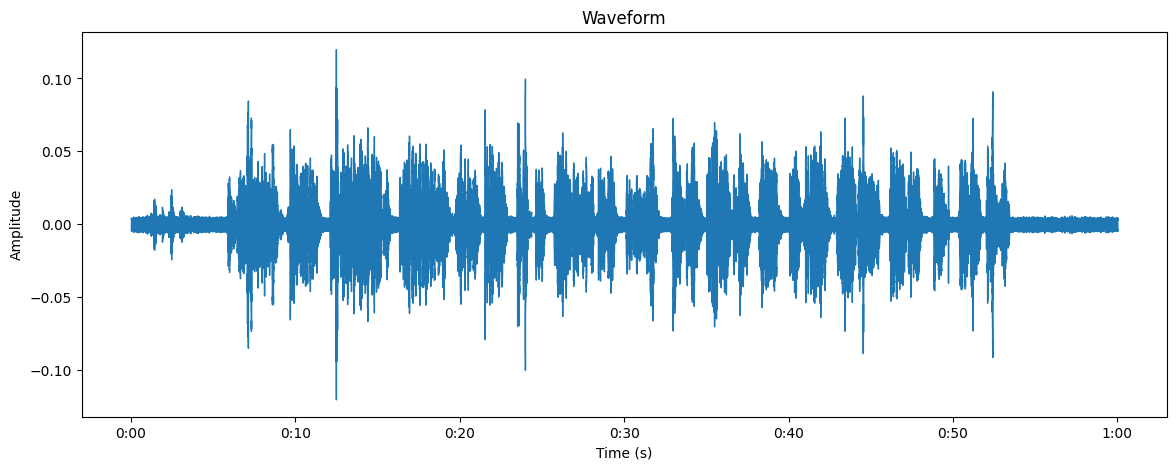

In [8]:
plt.figure(figsize=(14, 5))
librosa.display.waveshow(y, sr=sr)
plt.title("Waveform")
plt.xlabel("Time (s)")
plt.ylabel("Amplitude")
plt.show()

#### Spectrogram

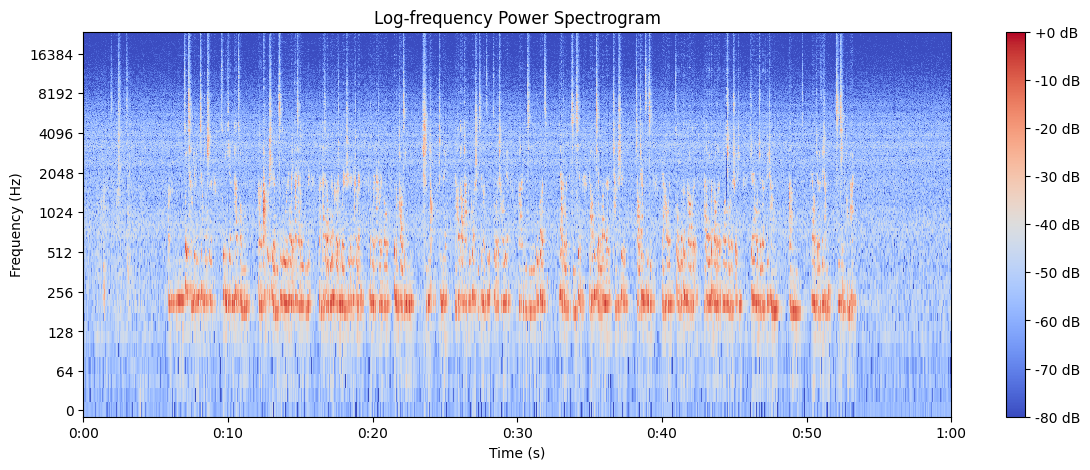

In [9]:
D = librosa.amplitude_to_db(np.abs(librosa.stft(y)), ref=np.max)
plt.figure(figsize=(14, 5))
librosa.display.specshow(D, sr=sr, x_axis='time', y_axis='log', cmap='coolwarm')
plt.colorbar(format="%+2.0f dB")
plt.title("Log-frequency Power Spectrogram")
plt.xlabel("Time (s)")
plt.ylabel("Frequency (Hz)")
plt.show()

#### Mel-frequency cepstral coefficients (MFCCs)

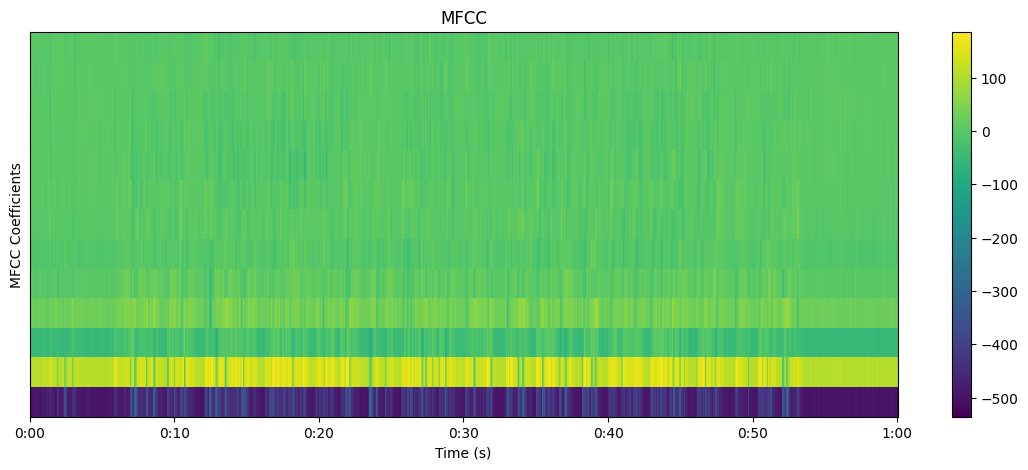

In [10]:
mfccs = librosa.feature.mfcc(y=y, sr=sr, n_mfcc=13)
plt.figure(figsize=(14, 5))
librosa.display.specshow(mfccs, x_axis='time', sr=sr, cmap='viridis')
plt.colorbar()
plt.title("MFCC")
plt.xlabel("Time (s)")
plt.ylabel("MFCC Coefficients")
plt.show()

#### Chroma Features

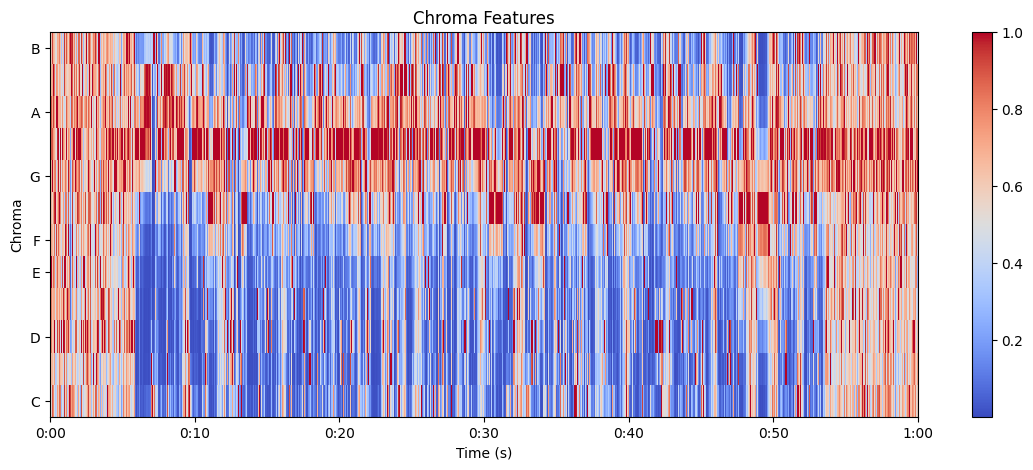

In [14]:
chroma = librosa.feature.chroma_stft(y=y, sr=sr)
plt.figure(figsize=(14, 5))
librosa.display.specshow(chroma, x_axis='time', y_axis='chroma', sr=sr, cmap='coolwarm')
plt.colorbar()
plt.title("Chroma Features")
plt.xlabel("Time (s)")
plt.ylabel("Chroma")
plt.show()

#### Zero-crossing rate

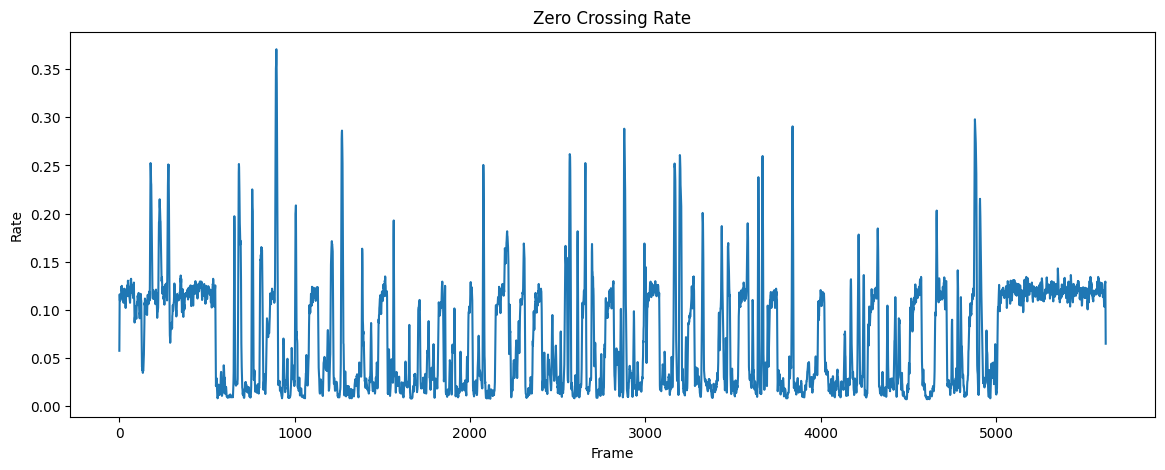

In [15]:
zcr = librosa.feature.zero_crossing_rate(y)
plt.figure(figsize=(14, 5))
plt.plot(zcr[0])
plt.title("Zero Crossing Rate")
plt.xlabel("Frame")
plt.ylabel("Rate")
plt.show()

#### Spectral Centroid

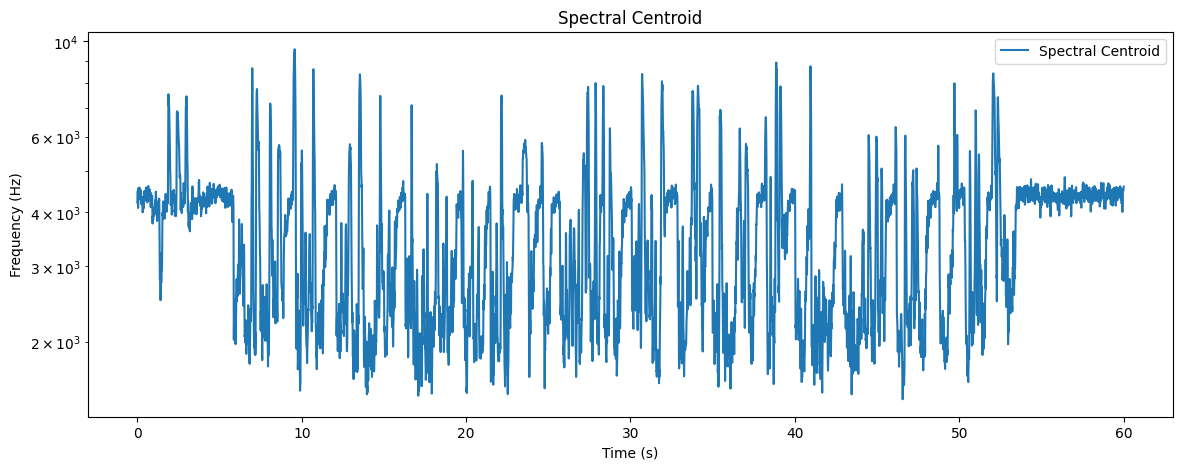

In [16]:
spectral_centroid = librosa.feature.spectral_centroid(y=y, sr=sr)[0]
frames = range(len(spectral_centroid))
times = librosa.frames_to_time(frames, sr=sr)
plt.figure(figsize=(14, 5))
plt.semilogy(times, spectral_centroid, label='Spectral Centroid')
plt.xlabel("Time (s)")
plt.ylabel("Frequency (Hz)")
plt.title("Spectral Centroid")
plt.legend()
plt.show()

#### Spectral Bandwidth

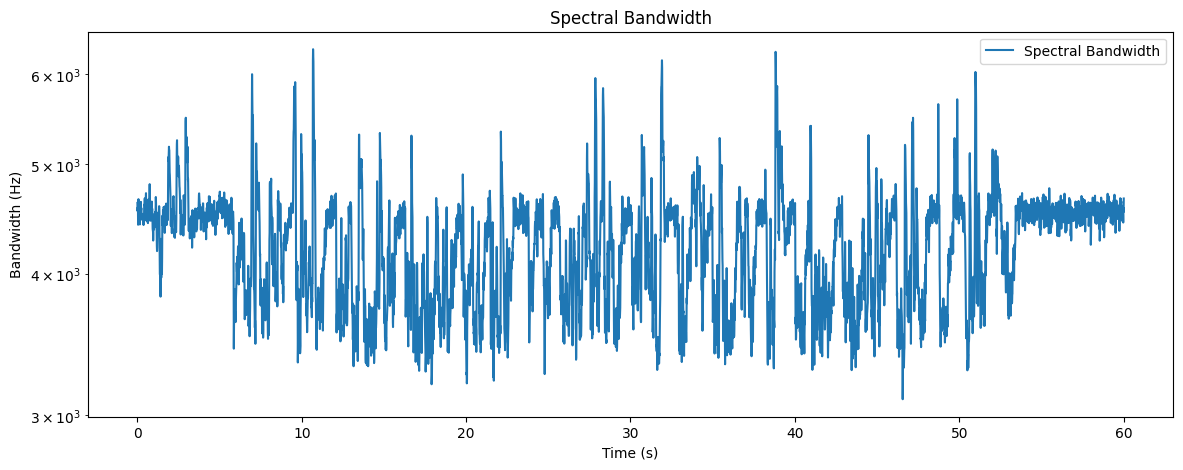

In [17]:
spectral_bandwidth = librosa.feature.spectral_bandwidth(y=y, sr=sr)[0]
plt.figure(figsize=(14, 5))
plt.semilogy(times, spectral_bandwidth, label='Spectral Bandwidth')
plt.xlabel("Time (s)")
plt.ylabel("Bandwidth (Hz)")
plt.title("Spectral Bandwidth")
plt.legend()
plt.show()

#### openSMILE GeMAPS

Eyben, F., Scherer, K. R., Schuller, B. W., Sundberg, J., André, E., Busso, C., ... & Truong, K. P. (2015). The Geneva minimalistic acoustic parameter set (GeMAPS) for voice research and affective computing. IEEE transactions on affective computing, 7(2), 190-202.

In [17]:
import opensmile
import pandas as pd

# Initialize the openSMILE object with an emotion-relevant configuration
smile = opensmile.Smile(
    feature_set=opensmile.FeatureSet.GeMAPS,  # Change to FeatureSet.IS09_emotion for IS09 features
    #feature_set=opensmile.FeatureSet.IS09_emotion,
    feature_level=opensmile.FeatureLevel.Functionals
)

# Extract features
features = smile.process_file(single_file_path)

# Display extracted features in a DataFrame
df_open_smile = features.reset_index()  # Convert index to columns for better readability

df_open_smile


,file,start,end,F0semitoneFrom27.5Hz_sma3nz_amean,F0semitoneFrom27.5Hz_sma3nz_stddevNorm,F0semitoneFrom27.5Hz_sma3nz_percentile20.0,F0semitoneFrom27.5Hz_sma3nz_percentile50.0,F0semitoneFrom27.5Hz_sma3nz_percentile80.0,F0semitoneFrom27.5Hz_sma3nz_pctlrange0-2,F0semitoneFrom27.5Hz_sma3nz_meanRisingSlope,...,alphaRatioUV_sma3nz_amean,hammarbergIndexUV_sma3nz_amean,slopeUV0-500_sma3nz_amean,slopeUV500-1500_sma3nz_amean,loudnessPeaksPerSec,VoicedSegmentsPerSec,MeanVoicedSegmentLengthSec,StddevVoicedSegmentLengthSec,MeanUnvoicedSegmentLength,StddevUnvoicedSegmentLength
0,/mnt/c/Working/Programming/Python/resources/ws...,0 days,0 days 00:01:00.010666667,34.677624,0.101524,33.606449,35.032471,36.16209,2.555641,290.586792,...,1.378979,3.919515,0.045775,-0.002412,2.05,1.18432,0.49169,0.433544,0.362154,0.96176


#### Features

In [19]:
# Extract features
features = {}

# 1. Zero-Crossing Rate
zcr = librosa.feature.zero_crossing_rate(y)[0]
features['zero_crossing_rate_mu'] = np.mean(zcr)
features['zero_crossing_rate_std'] = np.std(zcr)

# 2. Spectral Centroid
spectral_centroid = librosa.feature.spectral_centroid(y=y, sr=sr)[0]
features['spectral_centroid_mu'] = np.mean(spectral_centroid)
features['spectral_centroid_std'] = np.std(spectral_centroid)

# 3. Spectral Bandwidth
spectral_bandwidth = librosa.feature.spectral_bandwidth(y=y, sr=sr)[0]
features['spectral_bandwidth_mu'] = np.mean(spectral_bandwidth)
features['spectral_bandwidth_std'] = np.std(spectral_bandwidth)

# 4. MFCCs (Mel-frequency cepstral coefficients)
mfccs = librosa.feature.mfcc(y=y, sr=sr, n_mfcc=13)
for i, mfcc in enumerate(mfccs):
    features[f'mfcc_{i+1}_mu'] = np.mean(mfcc)
    features[f'mfcc_{i+1}_std'] = np.std(mfcc)

# 5. Chroma Features
chroma = librosa.feature.chroma_stft(y=y, sr=sr)
for i, chroma_value in enumerate(chroma):
    features[f'chroma_{i+1}_mu'] = np.mean(chroma_value)
    features[f'chroma_{i+1}_std'] = np.std(chroma_value)

# 6. Spectral Contrast
spectral_contrast = librosa.feature.spectral_contrast(y=y, sr=sr)
for i, contrast in enumerate(spectral_contrast):
    features[f'spectral_contrast_{i+1}_mu'] = np.mean(contrast)
    features[f'spectral_contrast_{i+1}_std'] = np.std(contrast)

# 7. Tonnetz (Tonal Centroids)
tonnetz = librosa.feature.tonnetz(y=librosa.effects.harmonic(y), sr=sr)
for i, tonnetz_value in enumerate(tonnetz):
    features[f'tonnetz_{i+1}_mu'] = np.mean(tonnetz_value)
    features[f'tonnetz_{i+1}_std'] = np.std(tonnetz_value)

# Convert features to a DataFrame for better presentation
df_librosa = pd.DataFrame([features])

In [22]:
combined_columns = pd.concat([df_librosa.reset_index(drop=True), df_open_smile.reset_index(drop=True)], axis=1)

In [23]:
combined_columns

,zero_crossing_rate_mu,zero_crossing_rate_std,spectral_centroid_mu,spectral_centroid_std,spectral_bandwidth_mu,spectral_bandwidth_std,mfcc_1_mu,mfcc_1_std,mfcc_2_mu,mfcc_2_std,...,alphaRatioUV_sma3nz_amean,hammarbergIndexUV_sma3nz_amean,slopeUV0-500_sma3nz_amean,slopeUV500-1500_sma3nz_amean,loudnessPeaksPerSec,VoicedSegmentsPerSec,MeanVoicedSegmentLengthSec,StddevVoicedSegmentLengthSec,MeanUnvoicedSegmentLength,StddevUnvoicedSegmentLength
0,0.070332,0.054759,3473.700735,1343.80708,4209.258639,471.188538,-451.133057,45.517933,120.23587,33.4744,...,1.378979,3.919515,0.045775,-0.002412,2.05,1.18432,0.49169,0.433544,0.362154,0.96176


In [9]:
speech_feature_extractor =  psychai.speech_acoustics.feature_extraction.feature_extraction.SpeechFeatureExtractor(segment_length=20, pick_chche_folder=pickle_folder_path)
speech_feature_extractor.segment_and_extract_features(single_file_path, extraction_methods=["librosa","opensmile"])

[File:PS-9_011_25_05_20_10_50_39_1.wav. Processed by librosa.]
[File:PS-9_011_25_05_20_10_50_39_1.wav. Processed by librosa.]
[File:PS-9_011_25_05_20_10_50_39_1.wav. Processed by librosa.]


,zero_crossing_rate_mu,zero_crossing_rate_std,spectral_centroid_mu,spectral_centroid_std,spectral_bandwidth_mu,spectral_bandwidth_std,mfcc_1_mu,mfcc_1_std,mfcc_2_mu,mfcc_2_std,...,tonnetz_2_std,tonnetz_3_mu,tonnetz_3_std,tonnetz_4_mu,tonnetz_4_std,tonnetz_5_mu,tonnetz_5_std,tonnetz_6_mu,tonnetz_6_std,seq
0,0.143572,0.105156,2530.227240,958.024677,2278.824207,274.254947,-397.444183,42.214909,76.866241,33.497768,...,0.092115,-0.036680,0.164343,0.067607,0.153397,-0.038272,0.050832,0.001996,0.070786,0.0
1,0.131341,0.101252,2487.951697,1027.053048,2262.685324,316.931314,-391.690735,43.091179,77.820343,39.153225,...,0.109784,0.018676,0.136368,0.055865,0.181976,-0.040284,0.055363,-0.011879,0.065645,1.0
2,0.152996,0.099759,2587.273634,894.310604,2274.431529,256.496966,-409.650787,41.747364,76.487549,32.795979,...,0.097094,-0.011566,0.129175,0.033685,0.160723,-0.033227,0.055660,-0.004732,0.051364,2.0


### Extract Features

In [20]:
speech_feature_extractor =  psychai.speech_acoustics.feature_extraction.feature_extraction.SpeechFeatureExtractor(segment_length=20, pick_chche_folder=pickle_folder_path)

In [5]:
df_largest

,user_id,modality,attribute_index,attribute_value,files,file_size,part_0,part_1,part_2,part_3,part_4,part_5,part_6,part_7,part_8,Group
0,11,Segment_Audio,2,25,/mnt/c/Working/Programming/Python/resources/ws...,11522126,PS-9,011,25,05,20,10,50,39,1.wav,3
1,11,Segment_Audio,2,26,/mnt/c/Working/Programming/Python/resources/ws...,8446030,PS-9,011,26,05,20,10,51,39,1.wav,3
2,11,Segment_Audio,2,27,/mnt/c/Working/Programming/Python/resources/ws...,9023566,PS-9,011,27,05,20,10,52,23,1.wav,3
3,11,Segment_Audio,2,28,/mnt/c/Working/Programming/Python/resources/ws...,8065102,PS-9,011,28,05,20,10,53,10,1.wav,3
4,13,Segment_Audio,2,25,/mnt/c/Working/Programming/Python/resources/ws...,20926542,PS-9,013,25,05,20,13,17,49,1.wav,2
5,13,Segment_Audio,2,26,/mnt/c/Working/Programming/Python/resources/ws...,2687054,PS-9,013,26,05,20,13,19,38,1.wav,2
6,13,Segment_Audio,2,27,/mnt/c/Working/Programming/Python/resources/ws...,4227150,PS-9,013,27,05,20,13,19,52,1.wav,2
7,13,Segment_Audio,2,28,/mnt/c/Working/Programming/Python/resources/ws...,2687054,PS-9,013,28,05,20,13,20,14,1.wav,2


In [6]:
# df_largest_trimmed = df_largest.copy()

# # Keep only the first row of the DataFrame
# df_largest_trimmed = df_largest.iloc[3:5]

# # Optionally reset the index if needed
# df_largest_trimmed.reset_index(drop=True, inplace=True)

In [7]:
from functools import partial
processor = psychai.feature.feature_extraction.feature_retriever.FeatureRetriever(df_largest, feature_extractors=[partial(speech_feature_extractor.segment_and_extract_features, extraction_methods=["librosa"])]
                             ,cache_file_path=pickle_file_path)

In [8]:
to_override = True 
if to_override == True:
    df_with_features = processor.extract_features(override= to_override)
    df_with_features.to_csv(csv_cache_file_path)
else:
    df_with_features = processor.extract_features(override= to_override)

Processing 8 items.


Extracting features:   0%|          | 0/8 [00:00<?, ?it/s]

Error processing item /mnt/c/Working/Programming/Python/resources/wsl2/examples/paper5_mmer_moral/resources/raw_data/013/Segment_Audio/PS-9_013_26_05_20_13_19_38_1.wav: Shape of passed values is (0, 1), indices imply (0, 0)
Error processing item /mnt/c/Working/Programming/Python/resources/wsl2/examples/paper5_mmer_moral/resources/raw_data/013/Segment_Audio/PS-9_013_28_05_20_13_20_14_1.wav: Shape of passed values is (0, 1), indices imply (0, 0)
[File:PS-9_013_27_05_20_13_19_52_1.wav. Processed by librosa.]
[File:PS-9_011_28_05_20_10_53_10_1.wav. Processed by librosa.]
[File:PS-9_011_26_05_20_10_51_39_1.wav. Processed by librosa.]
[File:PS-9_011_27_05_20_10_52_23_1.wav. Processed by librosa.]
[File:PS-9_011_25_05_20_10_50_39_1.wav. Processed by librosa.]
[File:PS-9_013_25_05_20_13_17_49_1.wav. Processed by librosa.]
[File:PS-9_011_26_05_20_10_51_39_1.wav. Processed by librosa.]
[File:PS-9_011_28_05_20_10_53_10_1.wav. Processed by librosa.]
[File:PS-9_011_27_05_20_10_52_23_1.wav. Processe

In [9]:
print(df_with_features)


    user_id       modality  attribute_index attribute_value  \
0        11  Segment_Audio                2              25   
1        11  Segment_Audio                2              25   
2        11  Segment_Audio                2              25   
3        11  Segment_Audio                2              26   
4        11  Segment_Audio                2              26   
5        11  Segment_Audio                2              27   
6        11  Segment_Audio                2              27   
7        11  Segment_Audio                2              28   
8        11  Segment_Audio                2              28   
9        13  Segment_Audio                2              25   
10       13  Segment_Audio                2              25   
11       13  Segment_Audio                2              25   
12       13  Segment_Audio                2              25   
13       13  Segment_Audio                2              25   
14       13  Segment_Audio                2            

In [10]:
df_with_features.columns

Index(['user_id', 'modality', 'attribute_index', 'attribute_value', 'files',
       'file_size', 'part_0', 'part_1', 'part_2', 'part_3',
       ...
       'librosa_contrast_4', 'librosa_contrast_5', 'librosa_contrast_6',
       'librosa_tonnetz_0', 'librosa_tonnetz_1', 'librosa_tonnetz_2',
       'librosa_tonnetz_3', 'librosa_tonnetz_4', 'librosa_tonnetz_5', 'seq'],
      dtype='object', length=210)

In [11]:
# Remove rows with at least one NaN
df_cleaned = df_with_features.dropna()
df_cleaned.reset_index(drop=True, inplace=True)

print("\nDataFrame after removing rows with at least one NaN:")
print(df_cleaned)


DataFrame after removing rows with at least one NaN:
    user_id       modality  attribute_index attribute_value  \
0        11  Segment_Audio                2              25   
1        11  Segment_Audio                2              25   
2        11  Segment_Audio                2              25   
3        11  Segment_Audio                2              26   
4        11  Segment_Audio                2              26   
5        11  Segment_Audio                2              27   
6        11  Segment_Audio                2              27   
7        11  Segment_Audio                2              28   
8        11  Segment_Audio                2              28   
9        13  Segment_Audio                2              25   
10       13  Segment_Audio                2              25   
11       13  Segment_Audio                2              25   
12       13  Segment_Audio                2              25   
13       13  Segment_Audio                2              25   
1

In [12]:
df_cleaned["librosa_tonnetz_5"]

0     0.001996
1    -0.011879
2    -0.004732
3    -0.015833
4    -0.009036
5    -0.014771
6    -0.013254
7    -0.007725
8    -0.013702
9    -0.014646
10   -0.004964
11   -0.006798
12   -0.029273
13   -0.021686
14   -0.016082
Name: librosa_tonnetz_5, dtype: float64

In [13]:
df_summary = speech_feature_extractor.summarized_data(df_cleaned)
df_summary

,mean_user_id,mean_attribute_index,mean_attribute_value,mean_file_size,mean_part_1,mean_part_2,mean_part_3,mean_part_4,mean_part_5,mean_part_6,...,end_to_begin_librosa_contrast_4,end_to_begin_librosa_contrast_5,end_to_begin_librosa_contrast_6,end_to_begin_librosa_tonnetz_0,end_to_begin_librosa_tonnetz_1,end_to_begin_librosa_tonnetz_2,end_to_begin_librosa_tonnetz_3,end_to_begin_librosa_tonnetz_4,end_to_begin_librosa_tonnetz_5,files
0,11.0,2.0,25.0,11522126.0,11.0,25.0,5.0,20.0,10.0,50.0,...,0.975071,1.000378,0.999774,0.530180,0.703833,0.315323,0.498242,0.868203,-2.369365,/mnt/c/Working/Programming/Python/resources/ws...
1,11.0,2.0,26.0,8446030.0,11.0,26.0,5.0,20.0,10.0,51.0,...,1.084206,1.022489,1.005296,-0.757773,4.264764,6.076721,1.525466,1.242215,0.570760,/mnt/c/Working/Programming/Python/resources/ws...
2,11.0,2.0,27.0,9023566.0,11.0,27.0,5.0,20.0,10.0,52.0,...,1.077195,1.005544,1.003747,-3.325256,2.980514,1.065873,1.529320,1.630423,0.897383,/mnt/c/Working/Programming/Python/resources/ws...
3,11.0,2.0,28.0,8065102.0,11.0,28.0,5.0,20.0,10.0,53.0,...,1.000609,0.993445,1.001622,0.282811,1.750701,0.449529,2.582591,1.471470,1.773813,/mnt/c/Working/Programming/Python/resources/ws...
4,13.0,2.0,25.0,20926542.0,13.0,25.0,5.0,20.0,13.0,17.0,...,1.040749,1.035111,0.995043,-0.665790,28.092981,2.943991,1.192715,-8.088285,2.598927,/mnt/c/Working/Programming/Python/resources/ws...
5,13.0,2.0,27.0,4227150.0,13.0,27.0,5.0,20.0,13.0,19.0,...,1.000000,1.000000,1.000000,1.000097,1.000079,1.000488,0.999921,1.000047,1.000062,/mnt/c/Working/Programming/Python/resources/ws...


In [14]:
df_merged = pd.merge(df_cleaned, df_summary, on='files', how='left')
df_merged.to_csv(csv_results_file_path)

## Footnote
- Copyright：Ivan Liu 
- Last Update: 2024
- Env：env41124
- References: 
    - https://github.com/PrudhviGNV/Speech-Emotion-Recognization